# **Assignment #3**
## **Introduction**
#### This document was developed by Mr. Emanuel Y. Gloria and Ms. Viel Celis as one of the academic requirement/assignment for the CMSC 210: Artificial Intelligence course for the Diploma in Computer Science degree.

#### *Please note that the data used in this assignment was acquired via survey by the aforementioned students. Also, the code below was written for purposes of showing all the steps in the model development process.*

##**Data Pre-processing**

In [ ]:
# Warning: The data was imported from Google Drive and this might not work
# for others who does not have my UP Mail credentials. Suggest to run the scripts
# on your local machine and create a working directory with the CSV file in it.

# Import the libraries to load the survey data from Google Drive
from google.colab import drive
import os
drive.mount('/content/drive')

# Set the search parameters
filename = 'Gloria-Celis_Use of Telehealth and Digital Health Tools.csv'
search_path = '/content/drive/My Drive/Diploma in Computer Science - UPOU Documents/Colab Notebooks/Data'

# Search for the file
for root, dirs, files in os.walk(search_path):
    if filename in files:
        file_path = os.path.join(root, filename)
        break

# Relevant libraries for the analyses
import pandas as pd
import numpy as np
from numpy.random.mtrand import standard_exponential

from sklearn.model_selection import train_test_split, GridSearchCV # Train and Test split and Parameter Tuning
from sklearn.tree import DecisionTreeClassifier, plot_tree         # Decision Tree Classifier
from sklearn.neighbors import KNeighborsClassifier                 # KNN Classifier
from sklearn.naive_bayes import GaussianNB                         # Naive Bayes Classifier
from sklearn.neural_network import MLPClassifier                   # Neural Network Classifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report          # Model results
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold, ShuffleSplit  # Cross validation
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler

import matplotlib.pyplot as plt                                    # Visualization
from matplotlib.colors import ListedColormap
import seaborn as sns
import math

import warnings

# To suppress all warnings
warnings.filterwarnings("ignore")

# Load the CSV file into a DataFrame
# Feel free to add the local file path here if you can't access the file via GDrive.
df = pd.read_csv(file_path)

# Step 1: Remove the following columns: Timestamp, Email Address, Name (Optional)
df = df.iloc[:,3:]

# Step 2: Rename column names
df.columns = ["age","sex","residence","occupation","q1","q2","q3","q4","q5","q6","q7",
 "q8","q9","q10","q11","q12","q13","q14","q15","q16","q17"]

#Step 3: Replace mislabeled and misspelled data entries
df["q5"].replace({'Not Applicable. (If you answered "No" in Q4.)':"Not applicable"}, inplace = True)
df["q12"].replace({"Note concerned":"Not concerned"}, inplace = True)

#Step 4: Convert nominal data from columns age, Q1, and Q11-14 to categorical
# and remap category orders
df["age"] = df["age"].astype("category")
df["age"] = df["age"].cat.reorder_categories(["18-25", "26-30", "31-35","36-40","41- above"])

df["q1"] = df["q1"].astype("category")
df["q1"] = df["q1"].cat.reorder_categories(["Low", "Moderate", "High"])

df["q11"] = df["q11"].astype("category")
df["q11"] = df["q11"].cat.reorder_categories(["Not applicable","Poor", "Fair", "Good", "Excellent"])

df["q12"] = df["q12"].astype("category")
df["q12"] = df["q12"].cat.reorder_categories(["Not concerned", "Somewhat concerned", "Concerned","Very concerned"])

df["q13"] = df["q13"].astype("category")
df["q13"] = df["q13"].cat.reorder_categories(["Not Applicable","None", "Minor", "Moderate", "Significant"])

df["q14"] = df["q14"].astype("category")
df["q14"] = df["q14"].cat.reorder_categories(["Limited", "Adequate", "Good", "Excellent"])

#Step 5: Remove anomalies in the numeric variables
# Remove the two outliers in q8 - respondents using their health apps. 20 and 24 on avg. a day
df["q8"].replace({20: np.nan,24: np.nan}, inplace = True)

#Step 6: Remove rows with NA
df = df.dropna()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Model Development**
### Artificial Neural Network
* (q1) Target Attribute: Level of Digital Health Adoption (Low, Moderate, and High)
* Other Attributes: (q7) Frequency of Telehealth Consultations, (q8) Time Spent on Health Applications (in hrs.), (q9) Trust in Telehealth (scale 1-5), and (q10) Digital Health Literacy Score (score 0-100)

In [ ]:
X = pd.get_dummies(df[["q7","q8","q9","q10"]])
y = df['q1']

# -------------- Step 1: Split the dataset into a training set and a testing set. --------------
x_train, x_test, y_train, y_test = train_test_split(X, y, train_size= 0.7, test_size=0.3, random_state=42)

#  -------------- Step 2: Before the actual learning process, the data must be normalized first. --------------
# MLP works best if the data is scaled in terms of [0,1] (Sigmoid), [-1,1] (Tanh), or [0, inf) (ReLU)  ranges
# Source: The DOST Summer School on AI, 2017)

##### Case 1: Sigmoid
sig_scaler = MinMaxScaler(feature_range=(0,1))
x_train_sig = sig_scaler.fit_transform(x_train)
x_test_sig = sig_scaler.transform(x_test)

##### Case 2: Tanh
tanh_scaler = MinMaxScaler(feature_range=(-1,1))
x_train_tanh = tanh_scaler.fit_transform(x_train)
x_test_tanh = tanh_scaler.transform(x_test)

##### Case 3: ReLU / Standard
relu_scaler = StandardScaler()
x_train_relu = relu_scaler.fit_transform(x_train)
x_test_relu = relu_scaler.transform(x_test)

# -------------- Step 3: Define hyperparameters for hyper parameter tuning --------------
param_grid = {
    'hidden_layer_sizes': [(1,), (5,), (10,), (50,), (100,)],
    'activation': ['logistic','relu', 'tanh'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate_init': [0.001, 0.01, 0.1],
    'max_iter': [200],
    'solver':['lbfgs', 'sgd', 'adam'],
    'batch_size': [50, 100]
}

# -------------- Step 4: Initialize the MLP Classifier and fit the classifier to the training data --------------

##### Case 1: Sigmoid (Default Model and Hyper Parameterized Model)
mlp_sig = MLPClassifier(hidden_layer_sizes=(10,),max_iter=200,learning_rate_init=0.001, activation='logistic',random_state=42)
mlp_sig.fit(x_train_sig,y_train)

mlp_sighp = MLPClassifier(random_state=42)
grid_search_sig = GridSearchCV(mlp_sighp, param_grid, cv=5, scoring='accuracy', n_jobs=-1) # Perform grid search with cross-validation
grid_search_sig.fit(x_train_sig, y_train)

best_params_sig = grid_search_sig.best_params_        # Get the best parameters
best_mlp_sig = MLPClassifier(**best_params_sig,random_state=42)       # Train the model with the best parameters
best_mlp_sig.fit(x_train_sig, y_train)

##### Case 2: Tanh (Default Model and Hyper Parameterized Model)
mlp_tanh = MLPClassifier(hidden_layer_sizes=(10,),max_iter=200,learning_rate_init=0.001, activation='tanh',random_state=42)
mlp_tanh.fit(x_train_tanh,y_train)

mlp_tanhhp = MLPClassifier(random_state=42)
grid_search_tanh = GridSearchCV(mlp_tanhhp, param_grid, cv=5, scoring='accuracy', n_jobs=-1) # Perform grid search with cross-validation
grid_search_tanh.fit(x_train_tanh,y_train)

best_params_tanh = grid_search_tanh.best_params_      # Get the best parameters
best_mlp_tanh = MLPClassifier(**best_params_tanh,random_state=42)     # Train the model with the best parameters
best_mlp_tanh.fit(x_train_tanh,y_train)

##### Case 3: ReLU / Standard (Default Model and Hyper Parameterized Model)
mlp_relu = MLPClassifier(hidden_layer_sizes=(10,),max_iter=200,learning_rate_init=0.001, activation='relu',random_state=42)
mlp_relu.fit(x_train_relu,y_train)

mlp_reluhp = MLPClassifier(random_state=42)
grid_search_relu = GridSearchCV(mlp_reluhp, param_grid, cv=5, scoring='accuracy', n_jobs=-1) # Perform grid search with cross-validation
grid_search_relu.fit(x_train_relu,y_train)

best_params_relu = grid_search_relu.best_params_      # Get the best parameters
best_mlp_relu = MLPClassifier(**best_params_relu,random_state=42)     # Train the model with the best parameters
best_mlp_relu.fit(x_train_relu,y_train)

# -------------- Step 5: Make predictions on the test data  --------------
y_pred_sig = mlp_sig.predict(x_test_sig)          # Sigmoid
y_pred_best_sig = best_mlp_sig.predict(x_test_sig)
y_pred_tanh = mlp_tanh.predict(x_test_tanh)       # Tanh
y_pred_best_tanh = best_mlp_tanh.predict(x_test_tanh)
y_pred_relu = mlp_relu.predict(x_test_relu)       # ReLU
y_pred_best_relu = best_mlp_relu.predict(x_test_relu)

# -------------- Step 6: Calculate the accuracy of the classifiers --------------
accuracy_sig = accuracy_score(y_test, y_pred_sig)
accuracy_best_sig = accuracy_score(y_test, y_pred_best_sig)
accuracy_tanh = accuracy_score(y_test, y_pred_tanh)
accuracy_best_tanh = accuracy_score(y_test, y_pred_best_tanh)
accuracy_relu = accuracy_score(y_test, y_pred_relu)
accuracy_best_relu = accuracy_score(y_test, y_pred_best_relu)

# -------------- Step 7: Print Results --------------
print("Case 1 (Default): Sigmoid")
print(f"Accuracy on training set: {mlp_sig.score(x_train_sig, y_train) * 100:.2f}%")
print(f"Accuracy on test set: {accuracy_sig * 100:.2f}%")

print("\nCase 1 (Best): Sigmoid")
print(f"Accuracy on training set: {best_mlp_sig.score(x_train_sig, y_train) * 100:.2f}%")
print(f"Accuracy on test set: {accuracy_best_sig * 100:.2f}%")

print("\n Case 2 (Default): TANH")
print(f"Accuracy on training set: {mlp_tanh.score(x_train_tanh, y_train) * 100:.2f}%")
print(f"Accuracy on test set: {accuracy_tanh  * 100:.2f}%")

print("\n Case 2 (Best):TANH")
print(f"Accuracy on training set: {best_mlp_tanh.score(x_train_tanh, y_train) * 100:.2f}%")
print(f"Accuracy on test set: {accuracy_best_tanh * 100:.2f}%")

print("\n Case 3 (Default): ReLU")
print(f"Accuracy on training set: {mlp_relu.score(x_train_relu, y_train) * 100:.2f}%")
print(f"Accuracy on test set: {accuracy_relu  * 100:.2f}%")

print("\n Case 3 (Best): ReLU")
print(f"Accuracy on training set: {best_mlp_relu.score(x_train_relu, y_train) * 100:.2f}%")
print(f"Accuracy on test set: {accuracy_best_relu * 100:.2f}%")

Case 1 (Default): Sigmoid
Accuracy on training set: 51.35%
Accuracy on test set: 58.82%

Case 1 (Best): Sigmoid
Accuracy on training set: 86.49%
Accuracy on test set: 41.18%

 Case 2 (Default): TANH
Accuracy on training set: 70.27%
Accuracy on test set: 52.94%

 Case 2 (Best):TANH
Accuracy on training set: 62.16%
Accuracy on test set: 64.71%

 Case 3 (Default): ReLU
Accuracy on training set: 67.57%
Accuracy on test set: 70.59%

 Case 3 (Best): ReLU
Accuracy on training set: 70.27%
Accuracy on test set: 64.71%


In [ ]:
best_mlp_relu.get_params()

{'activation': 'relu',
 'alpha': 0.0001,
 'batch_size': 50,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'early_stopping': False,
 'epsilon': 1e-08,
 'hidden_layer_sizes': (10,),
 'learning_rate': 'constant',
 'learning_rate_init': 0.001,
 'max_fun': 15000,
 'max_iter': 200,
 'momentum': 0.9,
 'n_iter_no_change': 10,
 'nesterovs_momentum': True,
 'power_t': 0.5,
 'random_state': 42,
 'shuffle': True,
 'solver': 'sgd',
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': False,
 'warm_start': False}

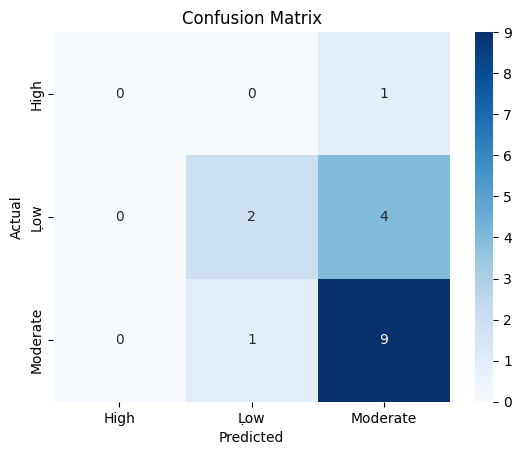


Classification Report:
               precision    recall  f1-score   support

        High     0.0000    0.0000    0.0000         1
         Ḷow     0.6667    0.3333    0.4444         6
    Moderate     0.6429    0.9000    0.7500        10

    accuracy                         0.6471        17
   macro avg     0.4365    0.4111    0.3981        17
weighted avg     0.6134    0.6471    0.5980        17



In [ ]:
# -------------- Step 8: Display the confusion matrix and classification report --------------
# Please note that beyond this point only the best model is used. In this case only Case 3 (Best): ReLU from the above is used.
conf_matrix = confusion_matrix(y_test, y_pred_best_relu)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["High", "Ḷow","Moderate"], yticklabels=["High", "Ḷow","Moderate"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Display classification report with precision, recall, and F1-score
report = classification_report(y_test, y_pred_best_relu, digits = 4, target_names=["High", "Ḷow","Moderate"])
print("\nClassification Report:\n", report)

## **Model Cross Validation**

In [ ]:
# Initialize cross-validation parameters
cv = 5                                                                                     # Standard k-folds
kfold = KFold(n_splits = 5, shuffle = True, random_state = 42)                               # Stratified
shuffle_split = ShuffleSplit(train_size=.7, test_size=.3, n_splits=5, random_state = 42)   # Shuffle

In [ ]:
#Standard Cross Validation
stan_score4 = cross_val_score(best_mlp_relu, relu_scaler.transform(X), y, cv=cv)
print("STANDARD CROSS VALIDATION\n")
print("Scores (DT): {}".format(stan_score4))
print("Average score (DT): {:.2f}".format(stan_score4.mean()))
print("\n")

#Stratified Cross Validation
strat_score4 = cross_val_score(best_mlp_relu, relu_scaler.transform(X), y, cv=kfold)
print("STRATIFIED CROSS VALIDATION\n")
print("Scores (DT): {}".format(strat_score4))
print("Average score (DT): {:.2f}".format(strat_score4.mean()))
print("\n")

#Shuffle-split Cross Validation
shuffle_score4 = cross_val_score(best_mlp_relu, relu_scaler.transform(X), y, cv=shuffle_split)
print("Shuffle-split CROSS VALIDATION\n")
print("Scores (DT): {}".format(shuffle_score4))
print("Average score (DT): {:.2f}".format(shuffle_score4.mean()))

STANDARD CROSS VALIDATION

Scores (DT): [0.81818182 0.63636364 0.36363636 0.72727273 0.5       ]
Average score (DT): 0.61


STRATIFIED CROSS VALIDATION

Scores (DT): [0.81818182 0.45454545 0.63636364 0.72727273 0.7       ]
Average score (DT): 0.67


Shuffle-split CROSS VALIDATION

Scores (DT): [0.64705882 0.64705882 0.35294118 0.58823529 0.58823529]
Average score (DT): 0.56


## **Further Analysis**

In [ ]:
# Case 1: Assuming 1 - 5 hidden layers with 5 neurons per layer - based on the best model parameter
param_grid_other_analysis = {
    'hidden_layer_sizes': [(5,), (5,5), (5,5,5), (5,5,5,5), (5,5,5,5,5)],
    'activation': ['relu'],
    'alpha': [0.0001],
    'learning_rate_init': [0.001],
    'max_iter': [200],
    'solver':['sgd'],
    'batch_size': [50]
}

# Generate a MLP Classifier
mlp = MLPClassifier(random_state=42)
grid_search = GridSearchCV(mlp, param_grid_other_analysis, cv=5, scoring='accuracy', n_jobs=-1) # Perform grid search with cross-validation

# Fit the training data to the model
grid_search.fit(x_train_relu,y_train)

# Get the best parameters
best_params = grid_search.best_params_
best_mlp = MLPClassifier(**best_params,random_state=42)
best_mlp.fit(x_train_relu,y_train)

# Predict using the best model
y_pred_best = best_mlp.predict(x_test_relu)
accuracy_best = accuracy_score(y_test, y_pred_best)

# Print Results
print(f"Accuracy on training set: {best_mlp.score(x_train_relu, y_train) * 100:.2f}%")
print(f"Accuracy on test set: {accuracy_best * 100:.2f}%")

# Access the search grid results
results = grid_search.cv_results_

# Print all the search grid results
i = 0
for mean_score, params in zip(results["mean_test_score"], results["params"]):
    i = i + 1
    print(f"{i}. Mean Test Score: {mean_score:.4f}, Hyperparameters: {params}")

Accuracy on training set: 64.86%
Accuracy on test set: 64.71%
1. Mean Test Score: 0.6179, Hyperparameters: {'activation': 'relu', 'alpha': 0.0001, 'batch_size': 50, 'hidden_layer_sizes': (5,), 'learning_rate_init': 0.001, 'max_iter': 200, 'solver': 'sgd'}
2. Mean Test Score: 0.5714, Hyperparameters: {'activation': 'relu', 'alpha': 0.0001, 'batch_size': 50, 'hidden_layer_sizes': (5, 5), 'learning_rate_init': 0.001, 'max_iter': 200, 'solver': 'sgd'}
3. Mean Test Score: 0.2964, Hyperparameters: {'activation': 'relu', 'alpha': 0.0001, 'batch_size': 50, 'hidden_layer_sizes': (5, 5, 5), 'learning_rate_init': 0.001, 'max_iter': 200, 'solver': 'sgd'}
4. Mean Test Score: 0.3786, Hyperparameters: {'activation': 'relu', 'alpha': 0.0001, 'batch_size': 50, 'hidden_layer_sizes': (5, 5, 5, 5), 'learning_rate_init': 0.001, 'max_iter': 200, 'solver': 'sgd'}
5. Mean Test Score: 0.6000, Hyperparameters: {'activation': 'relu', 'alpha': 0.0001, 'batch_size': 50, 'hidden_layer_sizes': (5, 5, 5, 5, 5), 'lear

In [ ]:
# Case 2: Assuming 1 hidden layer with 6, 10, 25, 50, 100, 250, 500 neurons per layer - based on the best model parameter
param_grid_other_analysis = {
    'hidden_layer_sizes': [(6,), (10,), (25,), (50,), (100,), (250,), (500,)],
    'activation': ['relu'],
    'alpha': [0.0001],
    'learning_rate_init': [0.001],
    'max_iter': [200],
    'solver':['sgd'],
    'batch_size': [50]
}

# Generate a MLP Classifier
mlp = MLPClassifier(random_state=42)
grid_search = GridSearchCV(mlp, param_grid_other_analysis, cv=5, scoring='accuracy', n_jobs=-1) # Perform grid search with cross-validation

# Fit the training data to the model
grid_search.fit(x_train_relu,y_train)

# Get the best parameters
best_params = grid_search.best_params_
best_mlp = MLPClassifier(**best_params,random_state=42)
best_mlp.fit(x_train_relu,y_train)

# Predict using the best model
y_pred_best = best_mlp.predict(x_test_relu)
accuracy_best = accuracy_score(y_test, y_pred_best)

# Print Results
print(f"Accuracy on training set: {best_mlp.score(x_train_relu, y_train) * 100:.2f}%")
print(f"Accuracy on test set: {accuracy_best * 100:.2f}%")

# Access the search grid results
results = grid_search.cv_results_

# Print all the search grid results
i = 0
for mean_score, params in zip(results["mean_test_score"], results["params"]):
    i = i + 1
    print(f"{i}. Mean Test Score: {mean_score:.4f}, Hyperparameters: {params}")

Accuracy on training set: 70.27%
Accuracy on test set: 64.71%
1. Mean Test Score: 0.5143, Hyperparameters: {'activation': 'relu', 'alpha': 0.0001, 'batch_size': 50, 'hidden_layer_sizes': (6,), 'learning_rate_init': 0.001, 'max_iter': 200, 'solver': 'sgd'}
2. Mean Test Score: 0.6571, Hyperparameters: {'activation': 'relu', 'alpha': 0.0001, 'batch_size': 50, 'hidden_layer_sizes': (10,), 'learning_rate_init': 0.001, 'max_iter': 200, 'solver': 'sgd'}
3. Mean Test Score: 0.4107, Hyperparameters: {'activation': 'relu', 'alpha': 0.0001, 'batch_size': 50, 'hidden_layer_sizes': (25,), 'learning_rate_init': 0.001, 'max_iter': 200, 'solver': 'sgd'}
4. Mean Test Score: 0.5214, Hyperparameters: {'activation': 'relu', 'alpha': 0.0001, 'batch_size': 50, 'hidden_layer_sizes': (50,), 'learning_rate_init': 0.001, 'max_iter': 200, 'solver': 'sgd'}
5. Mean Test Score: 0.5179, Hyperparameters: {'activation': 'relu', 'alpha': 0.0001, 'batch_size': 50, 'hidden_layer_sizes': (100,), 'learning_rate_init': 0.00